# WarpAffine

In this notebook you'll learn how to use `warp_affine` operation.

## Introduction

### Warp Operators

All warp operators work by calculating the output pixels by sampling the source image at transformed coordinates:

$${Out}(x, y) = {In}(x_{src}, y_{src})$$

This way each output pixel is calculated exactly once.

If the source coordinates do not point exactly to pixel centers, the values of neighboring pixels will be interpolated or the nearest pixel is taken, depending on the interpolation method specified in the `interp_type` argument.

### Affine Transform

The source sample coordinates $x_{src}, y_{src}$ are calculated according to the formula:

$$
\begin{vmatrix}
x_{src} \\
y_{src}
\end{vmatrix}
= \begin{vmatrix}
m_{00} & m_{01} & t_x \\
m_{10} & m_{11} & t_y
\end{vmatrix}
\begin{vmatrix}
{x} \\
{y} \\
1
\end{vmatrix}
$$

Where $x, y$ are coordinates of the destination pixel and the matrix represents the inverse (destination to source) affine transform. The 
$\begin{vmatrix}
m_{00} & m_{01} \\
m_{10} & m_{11}
\end{vmatrix}$ block represents a combined rotate/scale/shear transform and $t_x, t_y$ is a translation vector.

## Usage Example

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
import math
import os
from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import nvidia.dali.experimental.dynamic as ndd
import nvidia.dali.types as types

test_data_root = Path(os.environ["DALI_EXTRA_PATH"])
db_folder = test_data_root / "db" / "lmdb"

np.random.seed(seed=123)

# Load a single image using Caffe reader
reader = ndd.readers.Caffe(path=db_folder, random_shuffle=True, seed=12)
jpegs, labels = next(reader.next_epoch())
image = ndd.decoders.image(jpegs, device="cpu")

The function below defines an affine transform matrix for an image. The transform matrix is expected to be shape $2 \times 3$.

In [2]:
def random_transform() -> np.ndarray:
    dst_cx, dst_cy = (200, 200)
    src_cx, src_cy = (200, 200)

    # This function uses homogeneous coordinates - hence, 3x3 matrix

    # translate output coordinates to center defined by (dst_cx, dst_cy)
    t1 = np.array([[1, 0, -dst_cx], [0, 1, -dst_cy], [0, 0, 1]])

    def u():
        return np.random.uniform(-0.5, 0.5)

    # apply a randomized affine transform - uniform scaling + some random
    # distortion
    m = np.array([[1 + u(), u(), 0], [u(), 1 + u(), 0], [0, 0, 1]])

    # translate input coordinates to center (src_cx, src_cy)
    t2 = np.array([[1, 0, src_cx], [0, 1, src_cy], [0, 0, 1]])

    # combine the transforms
    m = np.matmul(t2, np.matmul(m, t1))

    # remove the last row; it's not used by affine transform
    return m[0:2, 0:3].astype(np.float32)

We apply the same transform to an image with different options.

The first variant executes on GPU and uses fixed output size and linear interpolation. It does not specify any fill value, in which case out-of-bounds destination coordinates are clamped to valid range.

The second executes on CPU and uses a `fill_value` argument which replaces the out-of-bounds source pixels with that value.

The last one executes on GPU and does not specify a new `size`, which keeps original image size.

In [3]:
transform = random_transform()
transform_cpu = ndd.as_tensor(transform)
transform_gpu = ndd.as_tensor(transform, device="gpu")
image_gpu = ndd.as_tensor(image, device="gpu")

warped_gpu = ndd.warp_affine(
    image_gpu,
    transform_gpu,  # pass the transform parameters through GPU memory
    size=(400, 400),  # specify the output size
    # fill_value,     # not specifying `fill_value` results in source coordinate clamping
    interp_type=types.INTERP_LINEAR,  # use linear interpolation
)

warped_cpu = ndd.warp_affine(
    image,
    matrix=transform_cpu,  # pass the transform through a named input
    fill_value=200,
    size=(400, 400),  # specify the output size
    interp_type=types.INTERP_NN,  # use nearest neighbor interpolation
)

warped_keep_size = ndd.warp_affine(
    image_gpu,
    transform_gpu,
    # size,           # keep the original canvas size
    interp_type=types.INTERP_LINEAR,  # use linear interpolation
)

## Example Output

Let's see the results:

Affine transform matrix:
[[ 1.1964692  -0.21386066  3.4782958 ]
 [-0.27314854  1.0513147  44.366756  ]]


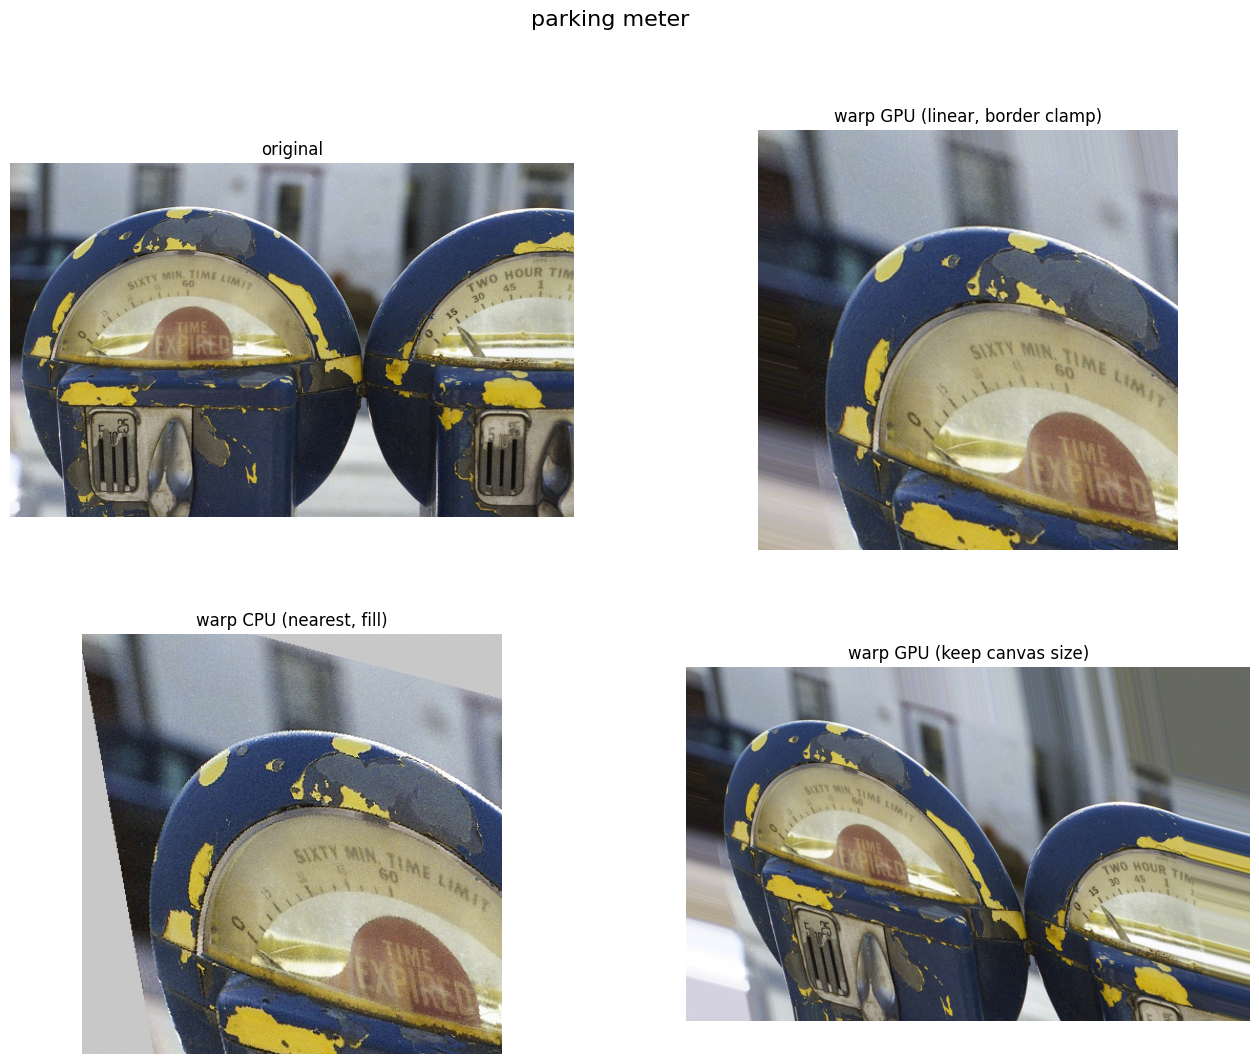

In [4]:
from synsets import imagenet_synsets

outputs = [image_gpu, warped_gpu, warped_cpu.gpu(), warped_keep_size]
captions = [
    "original",
    "warp GPU (linear, border clamp)",
    "warp CPU (nearest, fill)",
    "warp GPU (keep canvas size)",
]

fig = plt.figure(figsize=(16, 12))
label_idx = int(np.asarray(labels)[0])
plt.suptitle(imagenet_synsets[label_idx], fontsize=16)
columns = 2
rows = int(math.ceil(len(outputs) / columns))
gs = gridspec.GridSpec(rows, columns)

print("Affine transform matrix:")
print(transform)

for i in range(len(outputs)):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(captions[i])
    plt.imshow(np.asarray(outputs[i].cpu()) / 255.0)